# Conjecture Path Length

### Imports

In [1]:
%env CUDA_VISIBLE_DEVICES=""

env: CUDA_VISIBLE_DEVICES=""


## Notes
If it is directiobnal, none of the nodes are reachable
What about graph/nodes that are not ''conncted?``

## Aims:
* What are the conjecture path lengths?
* What is the average length - want to know how this relates to the number of MSG passing steps
* Is there a difference between positive and negative cojectures?
* Are all the subgraphs connected?

In [2]:
import sys
import os
from pathlib import Path
import networkx as nx
import numpy as np

sys.path.append(str(Path(os.path.abspath("")).parent))
from dataset import load_ids
from graph_parser import graph
import seaborn as sns

import config
from read_problem import read_problem_deepmath
from collections import Counter
from dataset import _process_problem

In [3]:
# Convert into graphs, then roll?

In [4]:
ID_FILE = '../id_files/deepmath.txt'
#ID_FILE = "../id_files/dev_100.txt"
# ID_FILE = '../id_files/validation.txt'

In [5]:
ids = load_ids(ID_FILE)

# Build graphs

In [6]:
res_connected = {}
res_distances = {}

In [7]:
remove_argument_node = True

In [8]:
for i in ids:

    data = _process_problem(i, config.PROBLEM_DIR, remove_argument_node=remove_argument_node)
    
    G = nx.Graph()    
    sources = np.array(data.edge_index[0].detach())
    targets = np.array(data.edge_index[1].detach())
    G.add_edges_from(list(zip(sources, targets)))

    res_connected[i] = nx.is_connected(G)

    lengths = []
    for p_index in data.premise_index:
        try:
            length = nx.shortest_path_length(G, source=data.conjecture_index[0].item(), target=p_index.item())
        except nx.NetworkXNoPath:
            length = -1

        lengths += [length]

    res_distances[i] = lengths

In [9]:
import itertools


def flatten(list2d):
    return list(itertools.chain(*list2d))

# Statistics

In [10]:
# Helper computation
flat_distances = flatten(res_distances.values())
flat_counter = Counter(flat_distances)
# print(flat_counter)

In [11]:
print("Number of problems: ", len(ids))

Number of problems:  32524


In [12]:
counter_connected = Counter(res_connected.values())
print("Connected graphs: ", counter_connected)

Connected graphs:  Counter({True: 32198, False: 326})


In [13]:
c = 0
for v in res_distances.values():
    if -1 in v:
        c += 1
print("Number of problems with non-reachable premise nodes:", c)
print(f"Propotion with non-reachable nodes: {c / len(ids):.2f}")

Number of problems with non-reachable premise nodes: 326
Propotion with non-reachable nodes: 0.01


In [14]:
print("Number of premise nodes:", len(flat_distances))
print("Number of non-reachable premise nodes (from conjecture):", flat_counter[-1])

Number of premise nodes: 522528
Number of non-reachable premise nodes (from conjecture): 367


In [15]:
print(f"Average conj-premise distance overall: {np.mean(flat_distances):.2f}")

Average conj-premise distance overall: 8.51


### Plot average distance per problem

In [16]:
avg_data = [np.mean(d) for d in list(res_distances.values())]

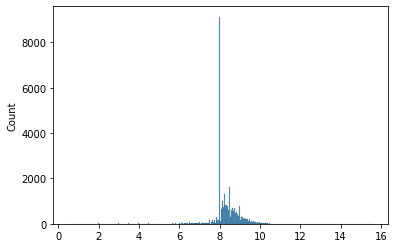

In [17]:
ax = sns.histplot(avg_data)

### Average distance based on positive and negative labels

In [18]:
neg_dist = [r[int(len(r) / 2) :] for r in list(res_distances.values())]
print(f"Print average conj-premise distance overall NEG nodes: {np.mean(flatten(neg_dist)):.2f}")

Print average conj-premise distance overall NEG nodes: 8.32


In [19]:
pos_dist = [r[: int(len(r) / 2)] for r in list(res_distances.values())]
print(f"Print average conj-premise distance overall POS nodes: {np.mean(flatten(pos_dist)):.2f}")

Print average conj-premise distance overall POS nodes: 8.70


## Non-reachable premises in neg/pos

In [20]:
print("Number of POS non-reachable premsies:", Counter(flatten(pos_dist))[-1])
print("Number of NEG non-reachable premsies:", Counter(flatten(neg_dist))[-1])

Number of POS non-reachable premsies: 1
Number of NEG non-reachable premsies: 366
